In [1]:
%load_ext autoreload
%autoreload 2

import jax
from env import NavigationEnv
from rooms import RoomParams, generate_rooms

TRAIN_SEED = 11

# Initialize our environment
env = NavigationEnv()

# Generate rooms
room_params = RoomParams(
    size=4.0,
    grid_size=8,
    target_carved_percent=0.5,
    num_rooms=512,
)
room_key = jax.random.PRNGKey(TRAIN_SEED)
obstacles, free_positions = generate_rooms(room_key, room_params)

# MLP

In [2]:
%load_ext autoreload
%autoreload 2

from models.mlp import MLP
import jax
import numpy as np
from env import EnvParams
from models.critic import Critic
from criteria.ppo import PPO
from criteria.gaussian_policy import GaussianPolicy
import jax
import time



MLP_MEM_LEN = 64

# Initialize environment parameters with generated rooms
env_params = EnvParams(
    lidar_max_distance=2.0,
    lidar_fov=120,
    lidar_num_beams=16,
    rooms=room_params,
    obstacles=obstacles,
    free_positions=free_positions,
    memory_init= lambda: MLP.initialize_state(MLP_MEM_LEN),
)

# Initialize the training algorithm parameters
mlp_config = {
    # Pass our environment to the agent
    "env": env,
    "env_params": env_params,
    # Number of timesteps during which the agent will be trained
    "total_timesteps": 10_000_000,
}

# Create the training algorithm agent from `rejax` library
ppo = PPO.create(**mlp_config)
mlp = MLP(hidden_size=[1024, 512], mem_len=MLP_MEM_LEN)

# actor = CPolicy(MLP([128, 128, 2]))
actor = GaussianPolicy(2, (np.array([-1., -1.]), np.array([1., 1.])), mlp)
# critic = VNetwork(MLP)([128, 128, 1])
ppo = ppo.replace(actor=actor, critic=Critic(mlp))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Set the seed for reproducibility


# Set training seed and jit train function
rng = jax.random.PRNGKey(TRAIN_SEED)
train_fn = jax.jit(ppo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = ppo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 306.905 seconds (32583.3 steps/second).


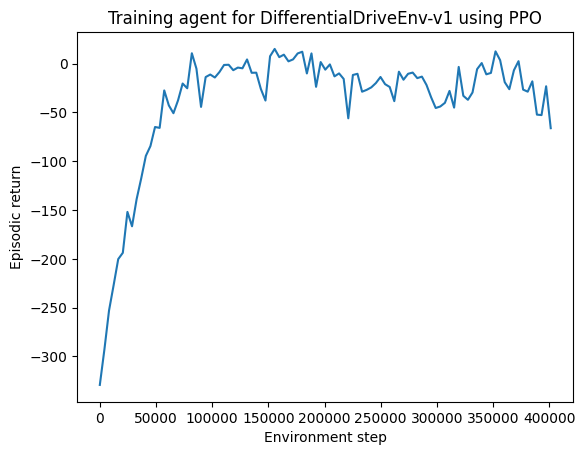

In [4]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, ppo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env.name} using {ppo.__class__.__name__}")
plt.show()

In [ ]:
from IPython.display import Image as IPImage, display
import env_vis
import os

# --- Configuration ---
N_EPISODES = 10  # Number of episodes to run
TEST_SEED = 43


# --- 1. Get Agent ---
t0 = time.time()
print("train state:", train_state)
act = jax.jit(ppo.make_act(train_state))
key = jax.random.PRNGKey(TEST_SEED)

# List to store frames for GIF
frames = []
total_steps = 0  # Keep track of total steps across episodes

print(f"Running {N_EPISODES} episodes and collecting frames...")

# --- 3. Run Episodes & Collect Frames ---
for i_episode in range(N_EPISODES):
    key, reset_key = jax.random.split(key)
    obs, state = env.reset(reset_key, env_params)
    done = False
    episode_steps = 0

    while not done:
        # Render current state to frame
        frame = env_vis.render_frame(state, env_params)
        frames.append(frame)

        # Choose action and step environment
        key, act_key, step_key = jax.random.split(key, 3)
        print(f"obs: {obs}, state: {state}, key: {key}")
        action = act(obs, act_key)
        print(f"action: {action}, obs: {obs}, state: {state}")

        obs, state, _, done, _ = env.step(step_key, state, action, env_params)
        
        episode_steps += 1

    print(f"  Episode {i_episode + 1} finished after {episode_steps} steps.")
    total_steps += episode_steps

print(f"Finished {N_EPISODES} episodes. Total steps: {total_steps}. Total frames: {len(frames)}.")

# --- 4. Save and Display GIF ---
print("Saving GIF...")
os.makedirs("temp", exist_ok=True)
gif_filename = "temp/navigation_policy.gif"
env_vis.save_gif(frames, gif_filename, duration_per_frame=env_params.dt)

# Display the GIF in the notebook
display(IPImage(filename=gif_filename))
print(f"GIF saved as {gif_filename}")

Running 10 episodes and collecting frames...
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
scale 600.0, start 3.25, h: 2400
obs: [ 3.25        2.75       -0.66713315  0.74493855  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.    

ValueError: cannot convert float NaN to integer

# LSTM

In [28]:
from models.lstm import LSTMMultiLayer
import jax
import numpy as np
from env import EnvParams
from models.critic import Critic
from criteria.ppo import PPO
from criteria.gaussian_policy import GaussianPolicy
import jax
import time


# Initialize environment parameters with generated rooms
lstm_env_params = EnvParams(
    lidar_max_distance=2.0,
    lidar_fov=120,
    lidar_num_beams=16,
    rooms=room_params,
    obstacles=obstacles,
    free_positions=free_positions,
    memory_init= lambda: LSTMMultiLayer.initialize_state(10, 10),
)

# Initialize the training algorithm parameters
lstm_config = {
    # Pass our environment to the agent
    "env": env,
    "env_params": lstm_env_params,
    # Number of timesteps during which the agent will be trained
    "total_timesteps": 1_000_000,
}

# Create the training algorithm agent from `rejax` library
ppo = PPO.create(**lstm_config)
lstm = LSTMMultiLayer(10, 10)

# actor = CPolicy(MLP([128, 128, 2]))
actor = GaussianPolicy(2, (np.array([-1., -1.]), np.array([1., 1.])), lstm)
# critic = VNetwork(MLP)([128, 128, 1])
ppo = ppo.replace(actor=actor, critic=Critic(lstm))









# Set the seed for reproducibility


# Set training seed and jit train function
rng = jax.random.PRNGKey(TRAIN_SEED)
train_fn = jax.jit(ppo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = ppo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 148.681 seconds (6725.81 steps/second).


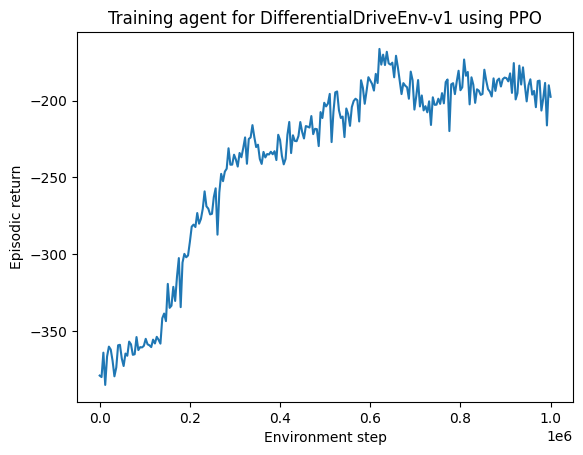

In [29]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, ppo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env.name} using {ppo.__class__.__name__}")
plt.show()

In [ ]:
from models.gtrxl import GTrXL
import jax
import numpy as np
from env import EnvParams
from models.critic import Critic
from criteria.ppo import PPO
from criteria.gaussian_policy import GaussianPolicy
import jax
import time


head_dim: int = 32
embedding_dim: int = 64
head_num: int = 2
mlp_num: int = 2
layer_num: int = 8
memory_len: int = 32

# Initialize environment parameters with generated rooms
lstm_env_params = EnvParams(
    lidar_max_distance=2.0,
    lidar_fov=120,
    lidar_num_beams=16,
    rooms=room_params,
    obstacles=obstacles,
    free_positions=free_positions,
    memory_init= lambda: gtrlx.init_memory(memory_len,embedding_dim,layer_num),
)

gtrlx = GTrXL(head_dim,embedding_dim,head_num,mlp_num,layer_num,memory_len)


# Initialize the training algorithm parameters
lstm_config = {
    # Pass our environment to the agent
    "env": env,
    "env_params": lstm_env_params,
    # Number of timesteps during which the agent will be trained
    "total_timesteps": 1_000_000,
}

# Create the training algorithm agent from `rejax` library
ppo = PPO.create(**lstm_config)
lstm = LSTMMultiLayer(10, 10)

# actor = CPolicy(MLP([128, 128, 2]))
actor = GaussianPolicy(2, (np.array([-1., -1.]), np.array([1., 1.])), gtrlx)
# critic = VNetwork(MLP)([128, 128, 1])
ppo = ppo.replace(actor=actor, critic=Critic(gtrlx))









# Set the seed for reproducibility


# Set training seed and jit train function
rng = jax.random.PRNGKey(TRAIN_SEED)
train_fn = jax.jit(ppo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = ppo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")